# Using the Replica Trick to Compute Marginal Entropies

In [14]:
import sys
from pathlib import Path
sys.path = list(set(sys.path + ["../python"]))

In [4]:
import numpy
import pandas as pd
from gaussian_system import System, time_matrix, log_marginal_entropy_power

In [21]:
path = Path.cwd().parent / "plots"
assert path.exists()
path

PosixPath('/Users/mr/Git/Gillespie/plots')

First define the system (i.e. the correlation functions)

In [75]:
system = System(lamda = 0.005, kappa = 0.25, rho = 0.01, mu = 0.01)

Set the trajectory length

In [6]:
traj_len = 500

In [43]:
def replica_estimate(sys: System, dim: int, delta_t: float, num_x: int, num_s: int, max_n: int):
    t = time_matrix(dim, delta_t)
    c_ss = sys.corr_ss(t)
    c_sx = sys.corr_sx(t)
    c_xs = sys.corr_xs(t)
    c_xx = sys.corr_xx(t)

    n = numpy.arange(1, max_n + 1)
    # this performs the monte carlo estimate of ln P(x)^n
    z_n = log_marginal_entropy_power(sys, t, num_x, num_s, n)
    return pd.DataFrame({"n": n, "logZ^n": z_n, "estimate": "replica", "num_responses": num_x, "num_signals": num_x*num_s*n, "dim": dim, "delta_t": delta_t})

In [29]:
def generate_replica_data():
    data = []
    for dim in numpy.linspace(100, 400, 6).astype(int):
        data.append(replica_estimate(sys, dim, traj_len/dim, 100, 200, 10))
    pd.concat(data, ignore_index=True).to_json(path / "replica" / "replica_data.json", orient="table")

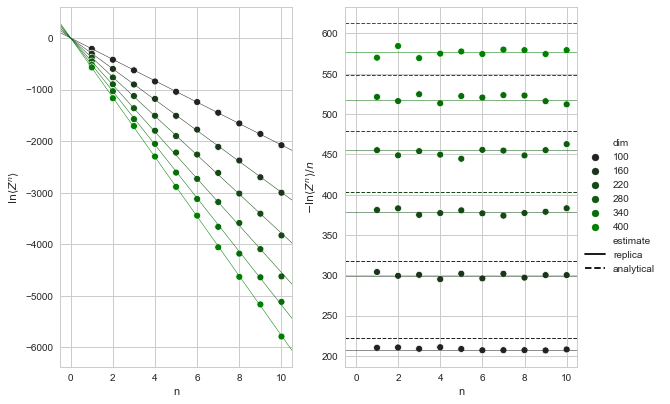

In [261]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')

replica_data = pd.read_json(path / "replica" / "replica_data.json", orient="table")

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, constrained_layout=True, subplot_kw={"xlim": (-0.5, 10.5)})
palette = sns.dark_palette("green", replica_data.dim.unique().size)
sns.scatterplot(x="n", y="logZ^n", hue="dim", palette=palette, data=replica_data, ax=ax1, legend=None)
sns.scatterplot(x="n", y="-logZ^n/n", hue="dim", palette=palette, data=replica_data.assign(**{'-logZ^n/n': lambda x: -x['logZ^n']/x.n}), ax=ax2, legend=None)

replica_estimate = pd.read_json(path / "replica" / "estimates.json", orient="table")
replica_estimate["analytical"] = replica_estimate.astype(object).apply(lambda s: system.marginal_entropy(time_matrix(s["dim"], s["delta_t"])), axis="columns")

for (i, est) in replica_estimate.iterrows():
    n = numpy.array(ax1.get_xlim())
    ax1.plot(n, -est['marginal_entropy']*n, color=palette[i], linewidth=0.5)
    ax2.plot(n, est['marginal_entropy']*numpy.ones_like(n), color=palette[i], linewidth=0.5)
    ax2.plot(n, est['analytical']*numpy.ones_like(n), linestyle='--', color=palette[i], linewidth=1)

ax1.set(ylabel=r"$\ln \langle Z^n \rangle$")
ax2.set(ylabel=r"$-\ln \langle Z^n \rangle / n$")

patch = matplotlib.pyplot.scatter
legend_handles = [patch([], [], visible=False, label="dim")]
for (i, est) in replica_estimate.iterrows():
    legend_handles.append(patch([], [], color=palette[i], label=int(est.dim)))
patch = matplotlib.lines.Line2D
legend_handles.append(patch([], [], visible=False, label="estimate", color='black'))
legend_handles.append(patch([], [], label="replica", color='black'))
legend_handles.append(patch([], [], linestyle='--', label="analytical", color='black'))

from matplotlib.legend_handler import HandlerCircleCollection

legend = fig.legend(handles=legend_handles, bbox_to_anchor=(1, 0.5), loc='center left')
fig.savefig(path / "replica" / "plot.pdf", bbox_inches='tight')

In [265]:
replica_data = pd.read_json(path / "replica" / "replica_data.json", orient="table")

def estimate_entropy_replica(data):
    def replica_marginal_entropy(data):
        import statsmodels.api as sm
        import statsmodels.formula.api as smf
        res = smf.ols("Q('logZ^n') ~ 0 + n", data=data).fit()
        return pd.Series({"num_signals": data.num_signals.sum(), "num_responses": data.num_responses.sum(), "marginal_entropy": -res.params[0], "stderr": res.bse[0]}, dtype=object)
    return data.groupby(["dim", "delta_t"]).apply(replica_marginal_entropy).reset_index()

result = estimate_entropy_replica(replica_data)
result.to_json(path / "replica" / "estimates.json", orient="table")
result

,dim,delta_t,num_signals,num_responses,marginal_entropy,stderr
0,100,5.000000,1100000,1000,207.593352,0.317150
1,160,3.125000,1100000,1000,299.439540,0.688098
2,220,2.272727,1100000,1000,378.861655,1.027208
3,280,1.785714,1100000,1000,454.998386,1.847585
4,340,1.470588,1100000,1000,517.991812,1.561831
5,400,1.250000,1100000,1000,577.397618,0.910386


In [267]:
pd.read_json(path / "replica" / "estimates-intercept.json", orient="table")

,dim,delta_t,num_signals,num_responses,marginal_entropy,stderr
0,100,5.000000,1100000,1000,206.556530,0.597532
1,160,3.125000,1100000,1000,299.679504,1.573723
2,220,2.272727,1100000,1000,380.024499,2.307476
3,280,1.785714,1100000,1000,459.019062,3.917831
4,340,1.470588,1100000,1000,515.529313,3.441177
5,400,1.250000,1100000,1000,578.678598,2.022415


In [263]:
result["analytical"] = result[["dim", "delta_t"]].astype(object).apply(lambda s: system.marginal_entropy(time_matrix(s["dim"], s["delta_t"])), axis="columns")

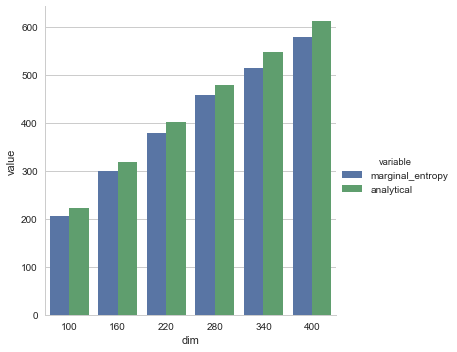

In [264]:
plot_data = result.melt(["dim", "delta_t", "num_signals", "num_responses"])
sns.catplot(x="dim", y="value", hue="variable", kind="bar", data=plot_data[plot_data.variable != "stderr"])

In [104]:
plot_data

,dim,delta_t,num_signals,variable,value
0,100,5.000000,1100000,num_responses,1000.000000
1,160,3.125000,1100000,num_responses,1000.000000
2,220,2.272727,1100000,num_responses,1000.000000
3,280,1.785714,1100000,num_responses,1000.000000
4,340,1.470588,1100000,num_responses,1000.000000
5,400,1.250000,1100000,num_responses,1000.000000
6,100,5.000000,1100000,marginal_entropy,207.593352
7,160,3.125000,1100000,marginal_entropy,299.439540
8,220,2.272727,1100000,marginal_entropy,378.861655
9,280,1.785714,1100000,marginal_entropy,454.998386
